# Home Credit Default Risk — EDA & Business Understanding

# Home Credit Default Risk
## Business Understanding & EDA (Application Table)

### *Objective*
* Predict the probability that a loan applicant will default (**TARGET = 1**) versus repay (**TARGET = 0**).
* This supports real-world credit risk decisions such as approval policies, interest rates, and risk monitoring.

### *Scope (Day 1)*
* Load train/test application tables
* Understand the target distribution (class imbalance)
* Inspect missingness and feature types
* Explore key numeric and categorical drivers of default risk
* Summarize findings and define next steps

# 1. Data Loading

### *Reproducibility*
* Data is stored in the `data/` directory at the project root.
* The notebook lives in `notebooks/`, so we build paths dynamically to avoid machine-specific absolute paths.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [12]:
train = pd.read_csv("../data/application_train.csv")
test  = pd.read_csv("../data/application_test.csv")

In [15]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Data Overview

### *What we have*
* `application_train.csv` includes features about the applicant and a target label (`TARGET`).
* `application_test.csv` includes the same features (without `TARGET`) for final predictions.

### *Identifiers*
* `SK_ID_CURR` is the unique customer/application identifier used for joins across other tables later.


In [16]:
train.shape

(307511, 122)

In [17]:
train.info

<bound method DataFrame.info of         SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0        

# 3. Target Variable Analysis

### *Why this matters*
* Default prediction datasets are typically **imbalanced** (most clients repay).
* We will validate models using **AUC**, which is appropriate for imbalanced classification.


In [18]:
target_counts = train["TARGET"].value_counts()
target_rate = train["TARGET"].mean()

print("TARGET counts:\n", target_counts)
print("\nDefault rate (TARGET=1):", round(target_rate, 4))

TARGET counts:
 TARGET
0    282686
1     24825
Name: count, dtype: int64

Default rate (TARGET=1): 0.0807


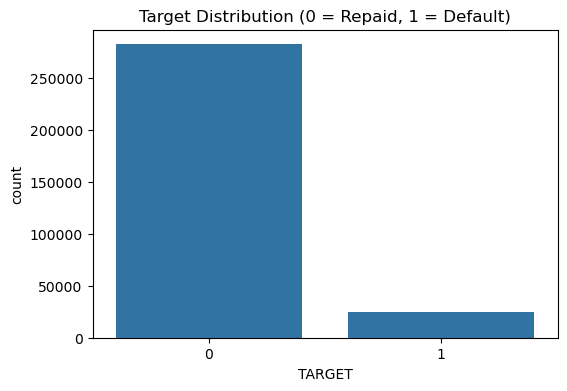

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x="TARGET", data=train)
plt.title("Target Distribution (0 = Repaid, 1 = Default)")
plt.show()

# 4. Missing Values Audit

### *Approach*
* Compute missing percentage per feature.
* Identify the most problematic columns early.
* Later, we will decide whether to:
  * impute
  * engineer missing indicators
  * or drop extremely sparse features


In [20]:
missing = train.isnull().mean().sort_values(ascending=False) * 100
missing_df = pd.DataFrame({"missing_%": missing, "dtype": train.dtypes}).reset_index()
missing_df.columns = ["feature", "missing_%", "dtype"]

In [21]:
missing_df.head(20)

,feature,missing_%,dtype
0,AMT_ANNUITY,0.003902,float64
1,AMT_CREDIT,0.000000,float64
2,AMT_GOODS_PRICE,0.090403,float64
3,AMT_INCOME_TOTAL,0.000000,float64
4,AMT_REQ_CREDIT_BUREAU_DAY,13.501631,float64
5,AMT_REQ_CREDIT_BUREAU_HOUR,13.501631,float64
6,AMT_REQ_CREDIT_BUREAU_MON,13.501631,float64
7,AMT_REQ_CREDIT_BUREAU_QRT,13.501631,float64
8,AMT_REQ_CREDIT_BUREAU_WEEK,13.501631,float64
9,AMT_REQ_CREDIT_BUREAU_YEAR,13.501631,float64


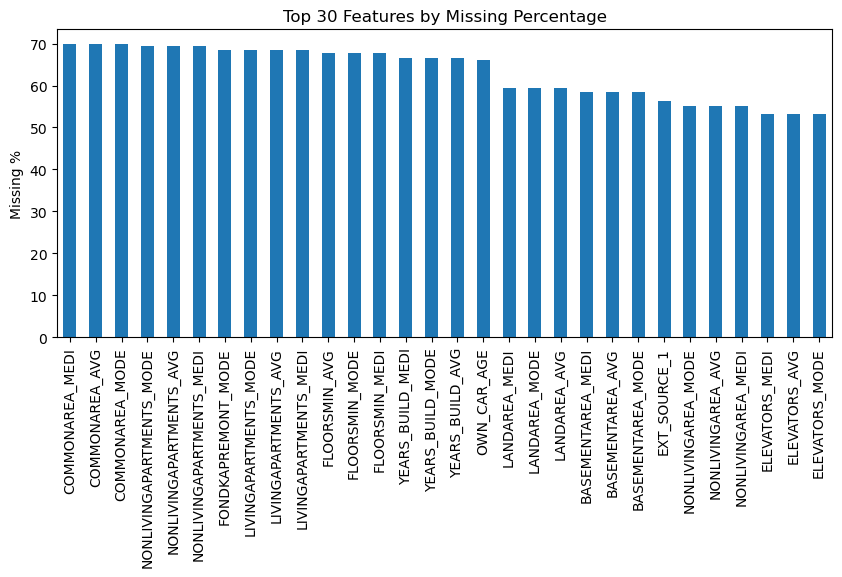

In [22]:
plt.figure(figsize=(10,4))
missing.head(30).plot(kind="bar")
plt.title("Top 30 Features by Missing Percentage")
plt.ylabel("Missing %")
plt.show()

# 5. Feature Types (Numeric vs Categorical)

### *Why this matters*
* Numeric features may require scaling/log transforms.
* Categorical features will need encoding (one-hot / target encoding).

In [24]:
num_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = train.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

cat_cols[:20]

Numeric columns: 106
Categorical columns: 16


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

# 6. Core Numeric Exploration

### *Key variables (typical credit risk drivers)*
* Income (`AMT_INCOME_TOTAL`)
* Credit amount (`AMT_CREDIT`)
* Annuity (`AMT_ANNUITY`)
* Age (derived from `DAYS_BIRTH`)

In [25]:
train["AGE_YEARS"] = (-train["DAYS_BIRTH"]) / 365.25

In [26]:
features = ["AGE_YEARS", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"]

train[features].describe().T

,count,mean,std,min,25%,50%,75%,max
AGE_YEARS,307511.0,43.906900,11.947950,20.503765,33.984942,43.12115,53.886379,6.907324e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.000000,112500.000000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.000000,270000.000000,513531.00000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.500000,16524.000000,24903.00000,34596.000000,2.580255e+05


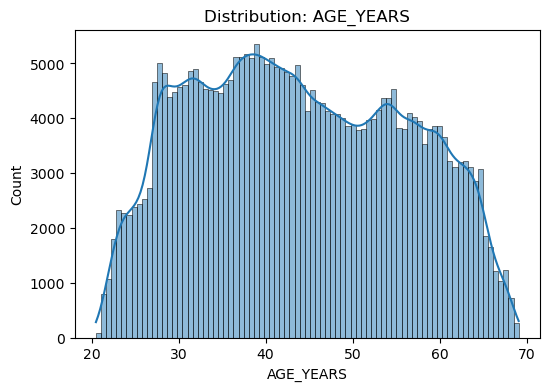

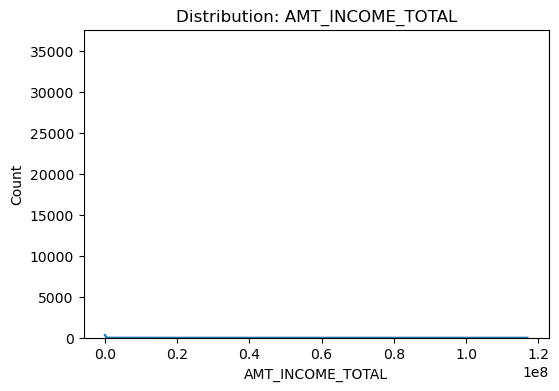

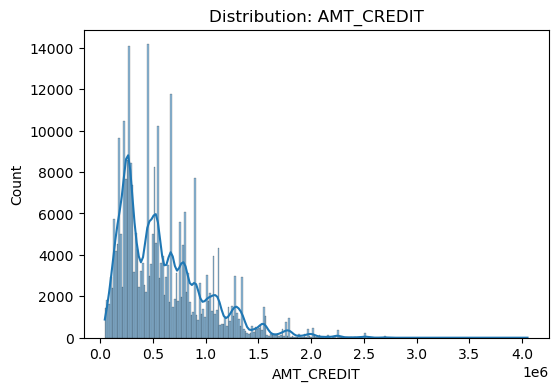

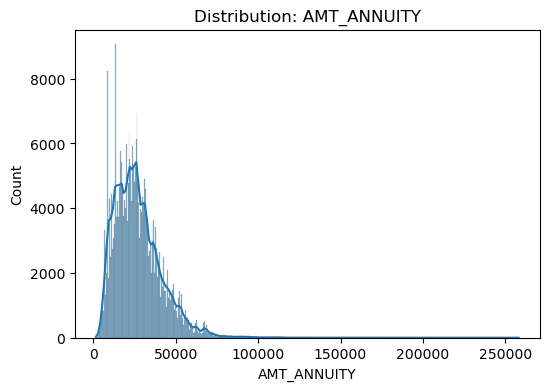

In [27]:
for col in features:
    plt.figure(figsize=(6,4))
    sns.histplot(train[col].dropna(), kde=True)
    plt.title(f"Distribution: {col}")
    plt.show()

In [28]:
train.groupby("TARGET")[features].median().T

TARGET,0,1
AGE_YEARS,43.468857,39.101985
AMT_INCOME_TOTAL,148500.000000,135000.000000
AMT_CREDIT,517788.000000,497520.000000
AMT_ANNUITY,24876.000000,25263.000000


# 7. Categorical Exploration

### *Goal*
* Identify categories with noticeably higher default rates.
* These often become strong engineered features later.


In [30]:
cat_to_check = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS"
]

for col in cat_to_check:
    rate = train.groupby(col)["TARGET"].mean().sort_values(ascending=False)
    display(rate.head(15))

NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
Name: TARGET, dtype: float64

CODE_GENDER
M      0.101419
F      0.069993
XNA    0.000000
Name: TARGET, dtype: float64

NAME_INCOME_TYPE
Maternity leave         0.400000
Unemployed              0.363636
Working                 0.095885
Commercial associate    0.074843
State servant           0.057550
Pensioner               0.053864
Businessman             0.000000
Student                 0.000000
Name: TARGET, dtype: float64

NAME_EDUCATION_TYPE
Lower secondary                  0.109277
Secondary / secondary special    0.089399
Incomplete higher                0.084850
Higher education                 0.053551
Academic degree                  0.018293
Name: TARGET, dtype: float64

NAME_FAMILY_STATUS
Civil marriage          0.099446
Single / not married    0.098077
Separated               0.081942
Married                 0.075599
Widow                   0.058242
Unknown                 0.000000
Name: TARGET, dtype: float64

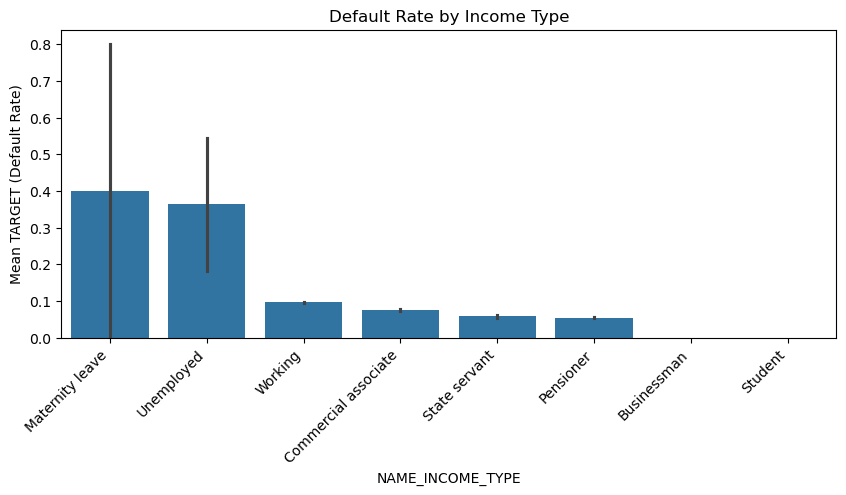

In [31]:
plt.figure(figsize=(10,4))
order = train.groupby("NAME_INCOME_TYPE")["TARGET"].mean().sort_values(ascending=False).index
sns.barplot(x="NAME_INCOME_TYPE", y="TARGET", data=train, order=order)
plt.xticks(rotation=45, ha="right")
plt.title("Default Rate by Income Type")
plt.ylabel("Mean TARGET (Default Rate)")
plt.show()

# 8. Quick Outlier Checks

### *Why this matters*
* Some numeric features contain extreme values that can distort models.
* Flag potential issues; we will handle them during preprocessing.


In [34]:
train[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"]].quantile([0.01, 0.5, 0.99]).T

,0.01,0.50,0.99
AMT_INCOME_TOTAL,45000.00,147150.0,472500.0
AMT_CREDIT,76410.00,513531.0,1854000.0
AMT_ANNUITY,6182.91,24903.0,70006.5


# 9. Key Findings

### *Observations*
* *[Write 5–8 bullets based on your results]*  
* Example format:
  * Applicants with **higher credit amounts** show higher observed default rates.
  * Certain **income types** have materially higher default rates than others.
  * The dataset is **highly imbalanced**, so we will focus on **AUC** and robust validation.
  * Several features have **high missingness**, requiring careful imputation/feature handling.


# 10. Next Steps 

### *Baseline model plan*
* Create train/validation split with stratification
* Impute missing numeric values (median)
* One-hot encode categoricals
* Train a baseline model (Logistic Regression or LightGBM)
* Evaluate with 5-fold Stratified CV (AUC)
